In [1]:
import pandas as pd
import numpy as np
import os
import sys
import scanpy as sc
import scipy
import time
import gget
from sklearn.decomposition import PCA
from kneed import KneeLocator

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.patheffects as pe

"""WARNING: disabling future warnings"""
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # and to omit tensorflow logging

""" Increase scanpy output"""
sc.settings.verbosity = 3

# local 
import utils as ut

In [2]:
fullpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/processed_data/all_clustered.h5ad"
raw = sc.read(fullpath)

# filter out non-neurons
adata = raw[raw.obs['cell_type'] == 'Neurons']
pdf = adata.copy()
pdf

AnnData object with n_obs × n_vars = 33647 × 25060
    obs: 'batch', 'reference_embedding_C7_named', 'reference_embedding_C25_named', 'C25_named', 'C7_named', 'reference_embedding_C7_named_clean', 'reference_embedding_C25_named_clean', 'C25_named_clean', 'C7_named_clean', 'UMAP1', 'UMAP2', 'Diet', 'Sex', 'broad_type', 'n_genes', 'color', 'leiden', 'cluster_num', 'Cluster', 'cluster_cat', 'U1', 'U2', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cluster', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

# Recluster Neurons

## PCA 

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
False    24060
True      1000
Name: highly_variable, dtype: int64

computing PCA
    on highly variable genes
    with n_comps=999
    finished (0:00:20)


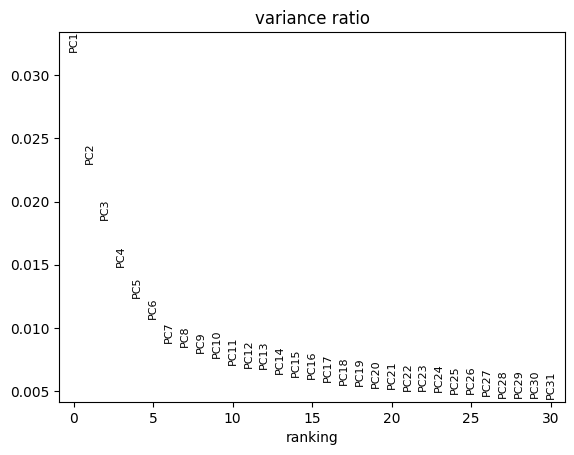

n_pca=999 explained_variance=1.0000


In [3]:
n_genes = 1000
n_pca = n_genes - 1  # full rank decomposition
# n_pca = 500

# recompute the highly varaible genes 
# sc.pp.highly_variable_genes(pdf,
#                             min_mean=0.0125, 
#                             max_mean=3, 
#                             min_disp=0.5,
#                            )

sc.pp.highly_variable_genes(pdf, n_top_genes=n_genes)

print(pdf.var['highly_variable'].value_counts())
print()

# recompute the PCA using just the neurons
sc.tl.pca(pdf, 
          n_comps=n_pca, 
          use_highly_variable=True)

# plot PCA results
sc.pl.pca_variance_ratio(pdf)

# print the total explained variance
explained_variance = pdf.uns['pca']['variance_ratio'].sum()

print(f"{n_pca=} {explained_variance=:0.4f}")

oht=381 knee=37


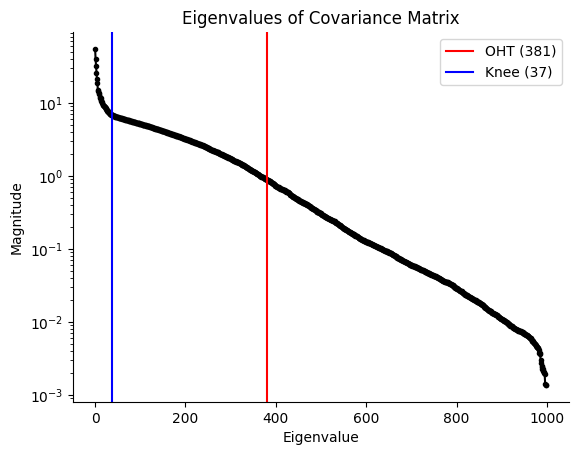

In [4]:
def get_hard_threshold(adata, plot=True):
    """A function to get the optimal hard threshold of a data matrix.
    Used to guide the choice of principal components """

    # OHT METHOD
    eigs = adata.uns['pca']['variance']
    tau = 2.858 * np.median(eigs)
    index = np.argwhere(eigs >= tau)
    oht = np.max(index) 

    # KNEED METHOD
    kneedle = KneeLocator(list(range(len(eigs))), 
                          eigs, 
                          S=1.0, 
                          curve="convex", 
                          direction="decreasing")
    knee = kneedle.knee
    print(f"{oht=} {knee=}")

    if plot:
        plt.plot(eigs, 
                 marker=".", 
                 c='k')
        plt.yscale('log')
        plt.ylabel(r"Magnitude")
        plt.xlabel("Eigenvalue")
        plt.title("Eigenvalues of Covariance Matrix")
        plt.axvline(x=oht, c='r', label=f'OHT ({oht})')
        plt.axvline(x=knee, c='b', label=f'Knee ({knee})')
        plt.legend()
        sns.despine()

get_hard_threshold(pdf)

In [5]:
# break

## Neighbors and clustering

computing PCA
    with n_comps=50
    finished (0:01:00)
n_pca=50 explained_variance=0.0919
computing neighbors
    using 'X_pca' with n_pcs = 50


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

    finished: added to `.uns['neuron_neighbors']`
    `.obsp['neuron_neighbors_distances']`, distances for each pair of neighbors
    `.obsp['neuron_neighbors_connectivities']`, weighted adjacency matrix (0:00:41)
running Leiden clustering
    finished: found 8 clusters and added
    'neuron_clusters', the cluster labels (adata.obs, categorical) (0:00:03)


... storing 'neuron_cluster_name' as categorical


0    21715
1     5573
2     1826
3     1460
4     1166
5      833
6      686
7      388
Name: neuron_clusters, dtype: int64


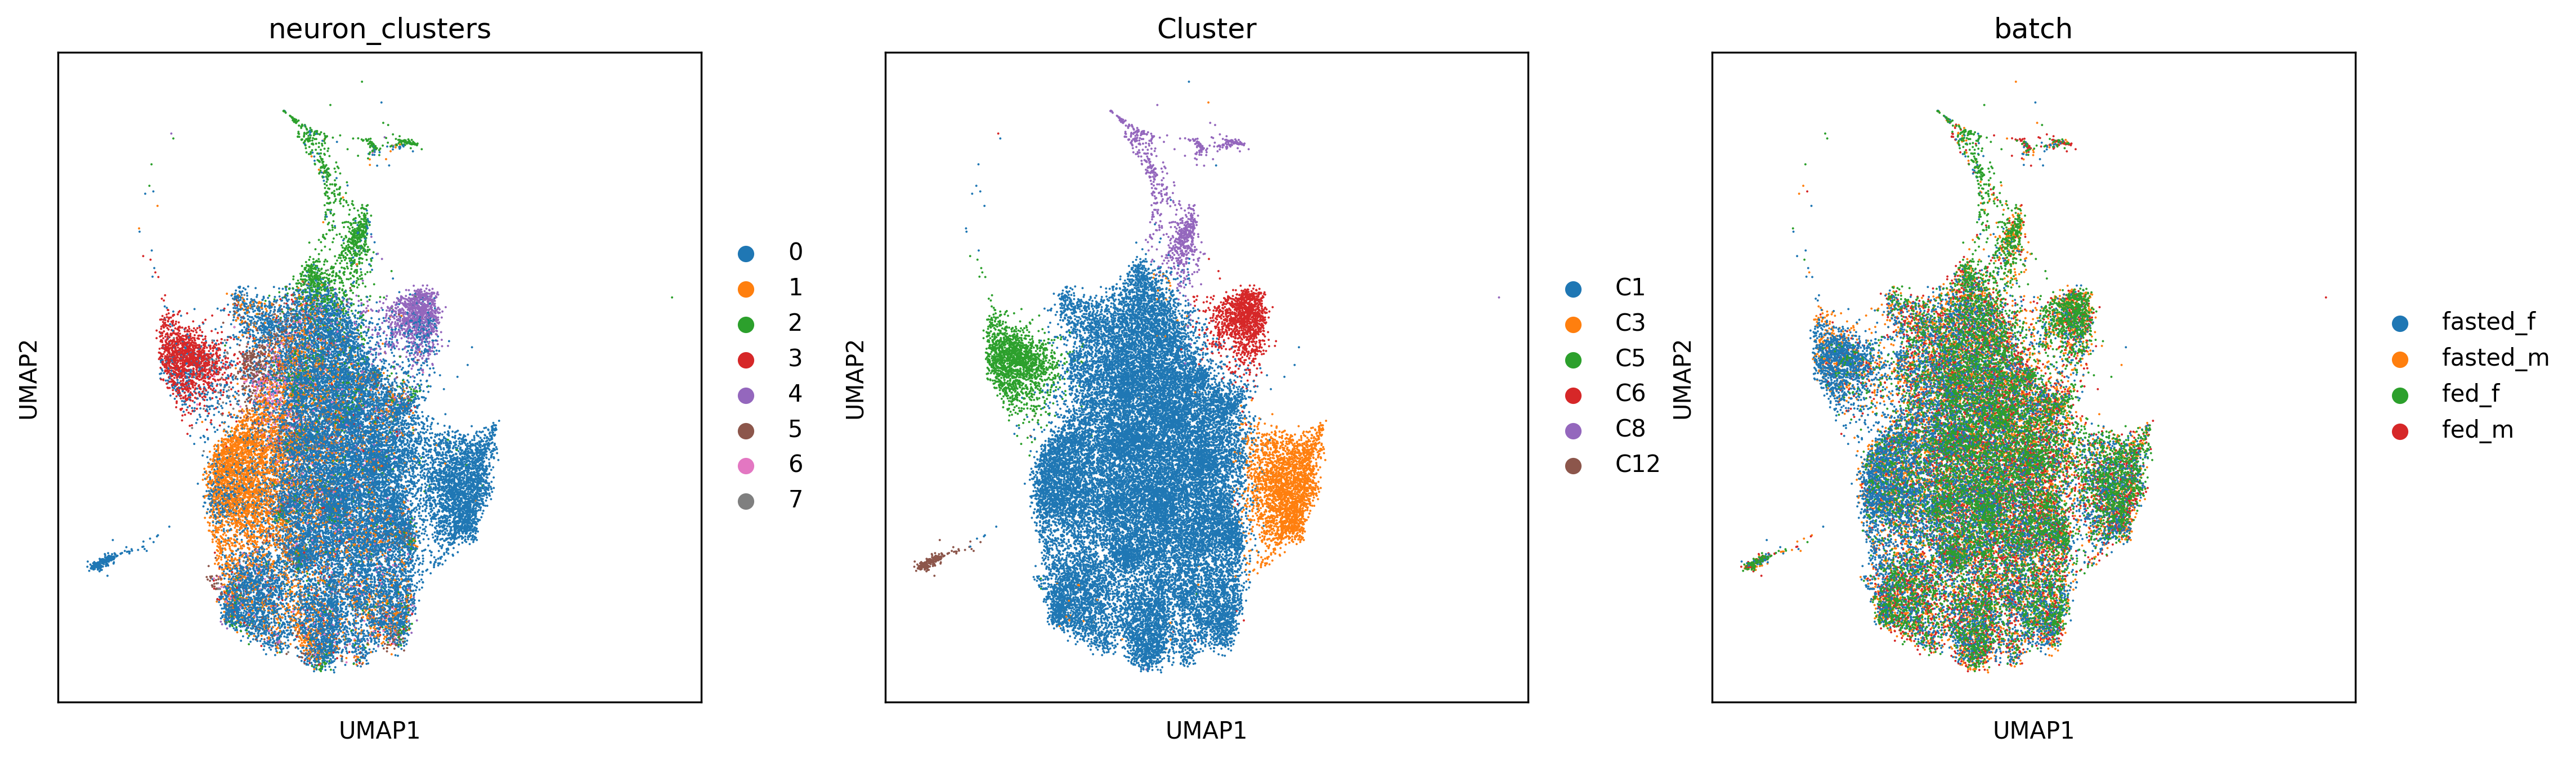

In [6]:
n_pca = 50 # from above 
n_neighbors = 15
resolution = 0.05

# recompute the PCA using just the neurons
sc.tl.pca(pdf, 
          n_comps=n_pca, 
          use_highly_variable=False)

explained_variance = pdf.uns['pca']['variance_ratio'].cumsum()[n_pca-1]
print(f"{n_pca=} {explained_variance=:.4f}")

# establish the nieghborhood
sc.pp.neighbors(pdf, 
                n_neighbors=n_neighbors, 
                n_pcs=n_pca,
                key_added='neuron_neighbors')

# perform clustering
sc.tl.leiden(pdf, 
             resolution=resolution,
             neighbors_key='neuron_neighbors',
             key_added='neuron_clusters')

# add new columns 
pdf.obs['neuron_cluster_num'] = pdf.obs['neuron_clusters'].astype(int) + 1
pdf.obs['neuron_cluster_name'] = "C" + pdf.obs['neuron_cluster_num'].astype(str)
pdf.obs['neuron_cluster_cat'] = pdf.obs['neuron_cluster_name'].astype('category')

# show results
print(pdf.obs['neuron_clusters'].value_counts())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

# note, this is on the old UMAP Coordinates
sc.pl.umap(pdf, color=['neuron_clusters', 'Cluster', 'batch'])

## New UMAP embedding

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP


/home/cstansbu/.local/lib/python3.9/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:25)


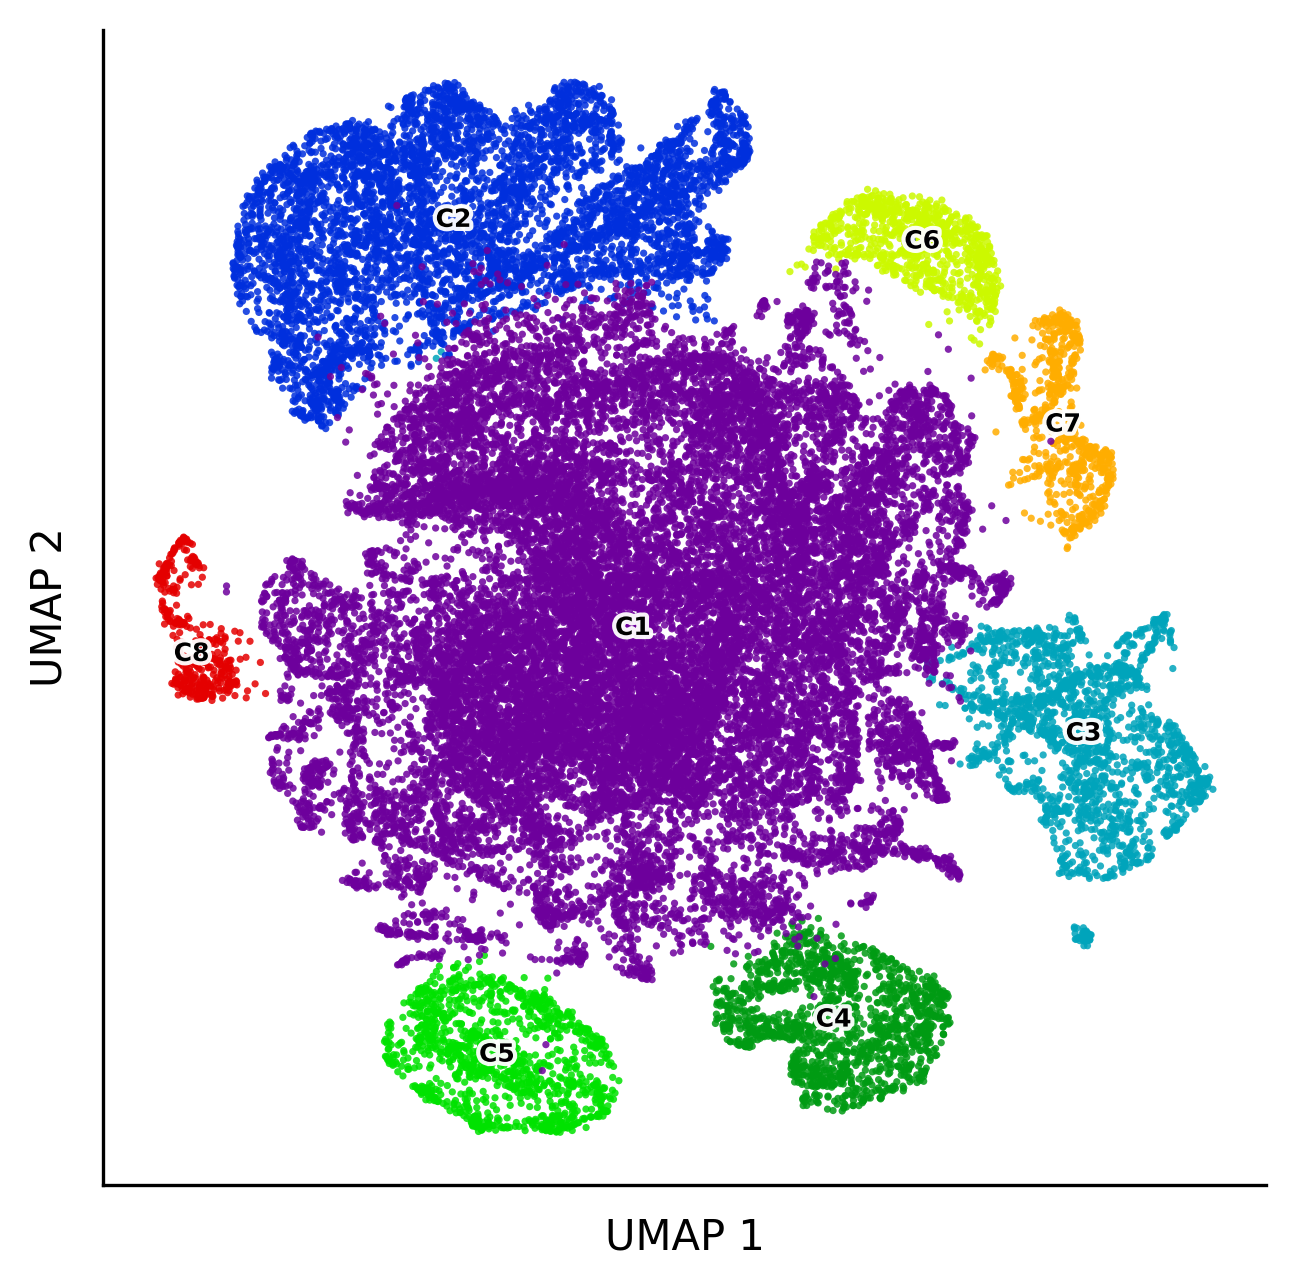

In [7]:
min_distance = 1.2
spread = 5.0
color_map = "nipy_spectral"

# build coarse-grained connectivity structures of complex manifolds 
sc.tl.paga(pdf, 
           groups='neuron_clusters',
           neighbors_key='neuron_neighbors',)

sc.pl.paga(pdf, plot=False)

# new embedding from the corse grained structures
sc.tl.umap(pdf, 
           init_pos='paga',
           neighbors_key='neuron_neighbors',
           min_dist=min_distance, 
           spread=spread)

# build new obs columns
pdf.obs['NU1'] = pdf.obsm['X_umap'][:, 0]
pdf.obs['NU2'] = pdf.obsm['X_umap'][:, 1]

""" UMAP PLOT """
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

# sort the data frame
pdx = pdf.obs.copy()
pdx = pdx.sort_values(by='cell_type')
pdx = pdx.reset_index()

hue_order = sorted(pdx['neuron_cluster_name'].unique())
order = np.argsort(pdx['neuron_cluster_name'])[::-1]

sns.scatterplot(data=pdx.iloc[order],
                x='NU1',
                y='NU2',
                hue='neuron_cluster_name',
                hue_order=hue_order,
                palette='nipy_spectral',
                s=3,
                alpha=0.85,
                ec='none'
        )

sns.despine()
plt.xticks([])
plt.yticks([])

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# label on data
ax = plt.gca()

all_pos = (
        pdx.groupby('neuron_cluster_name')[['NU1', 'NU2']]
        .median()
        .sort_index()
    )

for label, x_pos, y_pos in all_pos.itertuples():
    ax.text(
        x_pos,
        y_pos,
        label,
        weight='bold',
        path_effects=[pe.withStroke(linewidth=2, foreground="w", alpha=0.95,)],
        verticalalignment="center",
        horizontalalignment="center",
        fontsize='6',
    )

plt.gca().legend().remove()

In [8]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Write the data

In [9]:
# write the clustered data object
outpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/processed_data/all_subclustered.h5ad"
pdf.write(outpath)

print('done')


done


In [ ]:
break

# t-SNE

In [ ]:
# n_pcs = 15
# sc.tl.tsne(pdf, n_pcs=n_pcs)

# sc.pl.tsne(pdf, color=["neuron_clusters"])

# Diagnostic Plots

In [ ]:
sc.pl.umap(pdf, color=['neuron_clusters', 'Cluster'], ncols=2)

In [ ]:
sc.pl.umap(pdf, color=['neuron_clusters', 'batch', 'Sex', 'Diet'], ncols=2)

In [ ]:
pdf.obs['HypoMap'] = pdf.obs['reference_embedding_C7_named_clean'].astype('string').str.strip()
pdf.obs['HypoMap'] = np.where(~pdf.obs['HypoMap'].isin(['GABA', 'GLU']), 'Other', pdf.obs['HypoMap'])

sc.pl.umap(pdf, color=['neuron_clusters', 'Cluster', 'HypoMap'])

In [ ]:
gene_list = [
    'Npy',
    'Agrp',
    'Otp',
    'Lepr',
    'Ghr',
    'Acvr1c',
    'Nr5a2',
    'Corin',
    'Slco1a1'
]

sc.pl.umap(pdf, color=['neuron_clusters'] + gene_list, ncols=4)

In [ ]:
gene_list = [
    'Nr5a1', 
    'Gpr149', 
    'Fezf1',
    'Dlk1', 
    'Rprm',
    'Lepr',
    'Nfib', 
    'Foxp2',
    'Esr1'
]

sc.pl.umap(pdf, color=['neuron_clusters'] + gene_list, ncols=4)

In [ ]:
arcuate = ['Agrp','Npy','Sst','Ghrh','Th','Kiss1','Tac2','Pdyn','Cartpt','Pomc','Esr1',]
sc.pl.umap(pdf, color=['neuron_clusters'] + arcuate, ncols=4)

In [ ]:
VMH = ['Nr5a1','Gpr149','Fezf1','Dlk1','Rprm','Lepr','Nfib','Foxp2','Esr1',]
sc.pl.umap(pdf, color=['neuron_clusters'] + VMH, ncols=4)

# Write the Data!

In [ ]:
# write the clustered data object
outpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/processed_data/all_subclustered.h5ad"
pdf.write(outpath)

print('done')


In [ ]:
break

In [ ]:
gene_list = [
    'Npy',
    'Agrp',
    'Otp',
    'Lepr',
    'Ghr',
    'Acvr1c',
    'Nr5a2',
    'Corin',
    'Slco1a1'
    
] # must be q square

n = len(gene_list)
pltn = int(np.sqrt(n))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 5
fig, axs = plt.subplots(pltn, pltn)
axs = axs.ravel()

for i, g in enumerate(gene_list):
    v = pdf[:, [g]].X.todense()

    gdf = pdf.obs.copy()
    gdf['exp'] = np.ravel(v)

    order = np.argsort(gdf['exp'])

    axs[i].scatter(gdf['NU1'][order], 
                   gdf['NU2'][order],
                   c=gdf['exp'][order],
                   s=1,
                   alpha=0.9,
                   ec='none')
    
    axs[i].set_title(g)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")

sns.despine()
plt.tight_layout()

In [ ]:
gene_list = [
    'Nr5a1', 
    'Gpr149', 
    'Fezf1',
    'Dlk1', 
    'Rprm',
    'Lepr',
    'Nfib', 
    'Foxp2',
    'Esr1'
]

n = len(gene_list)
pltn = int(np.sqrt(n))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 5
fig, axs = plt.subplots(pltn, pltn)
axs = axs.ravel()

for i, g in enumerate(gene_list):
    v = pdf[:, [g]].X.todense()

    gdf = pdf.obs.copy()
    gdf['exp'] = np.ravel(v)

    order = np.argsort(gdf['exp'])

    axs[i].scatter(gdf['NU1'][order], 
                   gdf['NU2'][order],
                   c=gdf['exp'][order],
                   s=1,
                   alpha=0.9,
                   ec='none')
    
    axs[i].set_title(g)

    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")

sns.despine()
plt.tight_layout()

In [ ]:
threshold = 7
markers = {
    'AN' : ['AgRP','NPY','Sst','Ghrh','Th','DAT','Kiss1','Tac2','Pdyn','Cartpt','Pomc','Esr1',],
    'VMH' : ['Nr5a1','Gpr149','Fezf1','Dlk1','Rprm','LepR','Nfib','Foxp2','Cckrb','Esr1',],
}

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 3.75
fig, axs = plt.subplots(1, 2)
axs = axs.ravel()

for i, (label, gene_list) in enumerate(markers.items()):
    gene_list = [x.lower().capitalize() for x in gene_list if x.lower().capitalize() in pdf.var.index]
    print(label, gene_list)

    gdf = pdf.obs.copy()
    v = pdf[:, gene_list].X.todense()
    v = np.where(v > threshold, 1, 0)
    v = v.astype(bool).sum(axis=1)
#     v = np.mean(v, axis=1)
    print(v.shape)
    gdf['exp'] = np.ravel(v)
    order = np.argsort(gdf['exp'])

    axs[i].scatter(gdf['NU1'][order], 
                  gdf['NU2'][order],
                  c=gdf['exp'][order],
                  s=6,
                  alpha=0.9,
                  ec='none')
    
    axs[i].set_title(label)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")

sns.despine()
plt.tight_layout()

In [ ]:
break

# DEG

In [ ]:
key = 'Nueron_Cluster'
# get marker genes
sc.tl.rank_genes_groups(pdf, 
                        groupby=key,
                        method='wilcoxon',
                        key_added=key,
                        corr_method='benjamini-hochberg')

deg = sc.get.rank_genes_groups_df(pdf, 
                                  group=None,
                                  key=key)

deg.head()

In [ ]:
alpha = 0.05
n_print = 16

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 9, 9

for cluster, group in deg.groupby('group'):

    cdf = group[group['pvals_adj'] <= alpha]
    cdf = cdf[~cdf['names'].str.endswith("Rik")]
    cdf = cdf[~cdf['names'].str.startswith("MT-")]
    cdf = cdf[~cdf['names'].str.startswith("Gm")]

    cdf = cdf.sort_values(by='logfoldchanges', ascending=False,)
    label_genes = cdf['names'].head(n_print).to_list()
    label_genes.insert(0, None) # buffer top DEG so that it's plotted


    fig, axs = plt.subplots(4, 4)
    axs = axs.ravel()

    for i, g in enumerate(label_genes[:-1]):
        gdf = pdf.obs.copy()
        if i == 0:
            colors = np.where(gdf['Nueron_Cluster'] == cluster, 'r', 'lightgrey')
            order = np.argsort(colors)
            axs[i].scatter(gdf['NU1'][order], 
                           gdf['NU2'][order],
                           c=colors[order],
                           s=1,
                           alpha=0.2,
                           ec='none')
            axs[i].set_title("Cells")
        else:
            v = pdf[:, [g]].X.todense()
            gdf['exp'] = np.ravel(v)
        
            order = np.argsort(gdf['exp'])
        
            axs[i].scatter(gdf['NU1'][order], 
                           gdf['NU2'][order],
                           c=gdf['exp'][order],
                           s=1,
                           alpha=0.2,
                           ec='none')
            
            axs[i].set_title(g)

        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")

    plt.suptitle(f"Cluster {cluster}")
    sns.despine()
    plt.show()

# Build a metadata table

In [ ]:
#load in mouse TFs

fpath = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/processed_data/MOUSE_500bp_up_100bp_down_B.csv"

tdf = pd.read_csv(fpath)
tdf = tdf.rename(columns={'Unnamed: 0' : "TF"})
tdf = tdf.set_index("TF")
tdf = tdf.T
print(f"{tdf.shape=}")

tf_list = tdf.index.to_list()
print(f"{len(tf_list)=}")

tdf.head()


In [ ]:
# load neuropeptides
pep_path = "/nfs/turbo/umms-indikar/shared/projects/MC3R/neuropeptides/group-1902.csv"
ndf = pd.read_csv(pep_path, skiprows=1)

neuropeptides = ndf['Approved symbol'].unique()
print(f"{len(neuropeptides)=}")
ndf.head()

In [ ]:
res = []

lfc = 0
alpha = 0.05
top_genes = 100

for cluster, group in deg.groupby('group'):

    # filter insig and non upregulated, take the top genes
    group = group[group['pvals_adj'] <= alpha]
    group = group[group['logfoldchanges'] > lfc]
    group = group.sort_values(by='logfoldchanges', ascending=False)
    group = group.head(top_genes)

    group_genes = group['names'].to_list()
    print(f"{cluster} {len(group_genes)=}")

    # gene expression
    cdf = pdf[pdf.obs['Nueron_Cluster'] == cluster, group_genes].to_df()
    n_cells = cdf.shape[0]

    nonzero = pd.DataFrame(cdf.apply(np.count_nonzero, axis=0), columns=['nonzero'])

    cdf = cdf.agg(['mean', 'std', 'median', 'count', 'sum'], axis=0)
    cdf = cdf.T
    cdf = pd.merge(cdf, 
                   nonzero,
                   how='left',
                   left_index=True,
                   right_index=True,)
    cdf['perc_expressing'] = cdf['nonzero'] / n_cells
    cdf = cdf.reset_index(drop=False)
    cdf = cdf.rename(columns={'index' : 'gene_name'})
    cdf['is_TF'] = cdf['gene_name'].str.upper().isin(tf_list)
    cdf['is_neuropeptide'] = cdf['gene_name'].str.upper().isin(neuropeptides)

    cdf = pd.merge(group, cdf, 
                   how='left',
                   left_on='names',
                   right_on='gene_name')
    cdf = cdf.drop(columns='names')
    res.append(cdf)


res = pd.concat(res)
print(f"{res.shape=}")
res.head()

In [ ]:
# save the list
outpath = "neuron_clusters.csv"
res.to_csv(outpath, index=False)
res.head()

# Transcription factor ranking

In [ ]:
lfc = 0
alpha = 0.05
print_n = 5

for cluster, group in deg.groupby('group'):

    group = group[group['pvals_adj'] <= alpha]
    group = group[group['logfoldchanges'] > lfc]
    group = group.sort_values(by='logfoldchanges', ascending=False)

    group = group[group['names'].str.upper().isin(tf_list)]
    group = group.head(print_n)
    
    print(f"{cluster}: {', '.join(group['names'].to_list())}")
    

# Neuropeptide ranking


In [ ]:
lfc = 0
alpha = 0.05
print_n = 5

for cluster, group in deg.groupby('group'):

    group = group[group['pvals_adj'] <= alpha]
    group = group[group['logfoldchanges'] > lfc]
    group = group.sort_values(by='logfoldchanges', ascending=False)

    group = group[group['names'].str.upper().isin(neuropeptides)]
    group = group.head(print_n)
    
    print(f"{cluster}: {', '.join(group['names'].to_list())}")

In [ ]:
label_genes = [x.lower().capitalize() for x in neuropeptides]
label_genes = [x for x in label_genes if x in pdf.var_names]
print(f"{len(label_genes)=}")

sc.pl.heatmap(pdf, 
              label_genes, 
              groupby='Nueron_Cluster',
              show_gene_labels=True)

In [ ]:
label_genes = [
    'Mc3r',
    'Agrp',
    'Lepr',
    'Otp',
    'Acvr1c',
    'Dlk1',
    'Fezf1',
    'Nr5a1',
    'Pomc',
    'Crabp1',
    'Sst',
    'Bdnf',
    'Cartpt',
    'Ghrh',
    'Trh',
    'Tac2',
    'Tac1',
    'Mt2',
    'Coch',
    'Gal',
    'Nts',
    'Nfib',
    'Foxp2',
    'Adcyap1',
    'Esr1',]

print(f"{len(label_genes)=}")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 9, 9

fig, axs = plt.subplots(5, 5)
axs = axs.ravel()

for i, g in enumerate(label_genes):
    v = pdf[:, [g]].X.todense()

    gdf = pdf.obs.copy()
    gdf['exp'] = np.ravel(v)

    order = np.argsort(gdf['exp'])

    axs[i].scatter(gdf['NU1'][order], 
                   gdf['NU2'][order],
                   c=gdf['exp'][order],
                   s=2,
                   alpha=0.3,
                   ec='none')
    
    axs[i].set_xticks([])
    axs[i].set_yticks([])

    axs[i].set_xlabel("")
    axs[i].set_ylabel("")

    axs[i].set_title(g)


sns.despine()
plt.tight_layout()

# Manual Marker Sets

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

genes = [
    'AGRP',
    'GHR',
    # 'CART',
    'CARTPT',
    'POMC',
    "Oprm1",
    'GHRH',
    'SST',
    'TH',
    'KISS1',
    'KISS1R',
    'PDYN',
    'TAC2',
    # 'Tacr2',
    # 'NKB',
    'NR5A1',
    # 'MCH',
    'HCRT',
    # 'GRP50',
    'PCSK5',
    'GRP',
    # 'KISS1',
    'GAL',
    'NTS',
    # 'ERA',
    # 'ERB',
    'AR',
    'CHAT',
    'LEPR',
    'GHSR',
    'TRH',
    'CRH'
]

genes = [x.lower().capitalize() for x in genes]
not_in = [x for x in genes if not x in pdf.var_names]
print(not_in)

to_plot = ['Nueron_Cluster'] + genes

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
sc.pl.umap(pdf, color=to_plot)

# Allen Brain

In [ ]:
# alpha = 0.01
# n_query = 25
# percent_expressing = 0.20
# # db = "Allen_Brain_Atlas_10x_scRNA_2021"
# db = "Allen_Brain_Atlas_up"

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 9, 9

# for cluster, group in deg.groupby('group'):
#     print(f"{cluster}...")

#     cdf = group.copy()

#     # simple gene filters
#     # cdf = cdf[~cdf['names'].str.endswith("Rik")]
#     # cdf = cdf[~cdf['names'].str.startswith("MT-")]
#     # cdf = cdf[~cdf['names'].str.startswith("Gm")]

#     # filter and sort by differential expression
#     cdf = cdf[cdf['pvals_adj'] <= alpha]
#     cdf = cdf.sort_values(by='logfoldchanges', ascending=False)

#     """ FILTER OUT GENES NOT EXPRESSED IN MOST CELLS IN CLUSTER"""
#     cluser_genes = cdf['names'].to_list()
#     cluster_cells = pdf.obs[pdf.obs['Nueron_Cluster'] == cluster].index

#     # get raw counts
#     counts = pdf[cluster_cells, cluser_genes].layers['counts']

#     # get proportion pf cells expressing the gene
#     props = counts.astype(bool).sum(axis=0) / cdf.shape[0]
#     cdf['perc_of_cluster_expressing'] = np.ravel(props)

#     cdf = cdf[cdf['perc_of_cluster_expressing'] > percent_expressing]

#     query_genes = cdf['names'].head(n_query).values

#     print(query_genes)
    
#     edf = gget.enrichr(query_genes, database=db)
#     edf = edf[edf['adj_p_val'] <= 0.05]

#     for _, row in edf.head(30).iterrows():
#         print(f"{cluster=} {row['path_name']} (p={row['adj_p_val']:.4f})")

#     print()

In [ ]:
 # .break

In [ ]:
# nueron_map = {
#     'C1': 'Htr2c',
#     'C2': 'Ghrh/Asb4',
#     'C3': 'Nr5a1/Satb2',
#     'C4': 'Pax6',
#     'C5': 'Lmx1',
#     'C6' : 'Calcrl',
#     'C7': 'Foxb1/Rprm',
#     'C8': 'Agrp/Npy',
#     'C9': 'Ptpn3',
#     'C10': 'Junb',
#     'C11': 'Hdc',
# }

# pdf.obs['neuron_subtype'] = pdf.obs['Nueron_Cluster'].map(nueron_map)

# print(pdf.obs['neuron_subtype'].value_counts())

# def get_colors(data, cmap):
#     """A function to return seaborn colormap
#     dict from a colum """

#     color_list = sns.palettes.color_palette(cmap,
#                                             data.nunique(), 
#                                             as_cmap=False)
#     return color_list

# sc.pl.umap(pdf, 
#            color='neuron_subtype', 
#            legend_loc='on data', 
#            palette='hsv_r',
#            s=20,
#            alpha=0.5,
#            title='', 
#            frameon=False,)


In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 3

sc.pl.rank_genes_groups_heatmap(pdf, 
                                n_genes=5, 
                                groupby='Nueron_Cluster',
                                key='Nueron_Cluster',
                                cmap='viridis', 
                                figsize=(10,7))

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 3

sc.pl.rank_genes_groups_dotplot(pdf, 
                                n_genes=3, 
                                values_to_plot='logfoldchanges',
                                vmax=7, 
                                vmin=-7,
                                cmap='RdYlBu_r',
                                key='Nueron_Cluster',)

# DEG by sex

In [ ]:
res = []

for cell_type in pdf.obs['Nueron_Cluster'].unique():

    print(f"{cell_type}...")

    # subset the data by cell type
    cdf = pdf[pdf.obs['Nueron_Cluster'] == cell_type].copy()

    key = f'{cell_type}_by_diet'

    sc.tl.rank_genes_groups(cdf, 
                            groupby='Diet',
                            method='wilcoxon',
                            key_added=key,
                            corr_method='benjamini-hochberg')

    deg = sc.get.rank_genes_groups_df(cdf, 
                                      group='fasted',
                                      key=key)


    
    deg['cell_type'] = cell_type
    res.append(deg)

res = pd.concat(res)
print(f"{res.shape=}")
res.head()

In [ ]:
# Volcano plots

cluster = 'C6'
fold_change_upper_bound = 10
alpha = 0.01
pdx = res.copy()


pdx = pdx[pdx['cell_type'] == cluster]

pdx['logp'] = -1 * np.log10(pdx['pvals'])
pdx = pdx[pdx['logfoldchanges'].abs() < fold_change_upper_bound]
pdx = pdx[pdx['pvals'] <= alpha]

label_list = [
    'Agrp',
    'Ghr',
    'Lepr',
    'Gabrb3',
    'Grin1',
    'Pomc',
    'Negr1',
    'Npy',
    'Sybu',
    'Nrxn1',
]


pdx['color'] = np.where(pdx['names'].isin(label_list), 'r', 'lightgrey')
pdx = pdx.sort_values(by='color')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

sns.scatterplot(data=pdx, 
            x='logfoldchanges',
            y='logp',
            ec='none',
            c=pdx['color'].to_list(),
            alpha=0.8,
            zorder=1,
            s=4)

plt.ylabel(r"-log$_{10}$($p$-value)")
plt.xlabel(r"Fold Change (log$_{2}$)")
plt.axvline(x=0, lw=0.5, ls="--", c='k', zorder=2)


ax = plt.gca()

label_df = pdx[pdx['names'].isin(label_list)]
ut.label_point(label_df['logfoldchanges'], 
            label_df['logp'], 
            label_df['names'], 
            ax) 

sns.despine()

pdx = pdx.sort_values(by='logp', ascending=False)
pdx.head(40)

In [ ]:
# Volcano plots

cluster = 'C6'
fold_change_upper_bound = 10
alpha = 0.01
pdx = res.copy()


pdx = pdx[pdx['cell_type'] == cluster]

pdx['logp'] = -1 * np.log10(pdx['pvals'])
pdx = pdx[pdx['logfoldchanges'].abs() < fold_change_upper_bound]
pdx = pdx[pdx['pvals'] <= alpha]

label_list = [
    'AGRP',
    'GHR',
    # 'CART',
    'CARTPT',
    'POMC',
    'GHRH',
    'SST',
    'TH',
    'KISS1',
    'PDYN',
    # 'NKB',
    'NR5A1',
    # 'MCH',
    'HCRT',
    # 'GRP50',
    'PCSK5',
    'GRP',
    'KISS1',
    'GAL',
    'NTS',
    # 'ERA',
    # 'ERB',
    'AR',
    'CHAT',
    'LEPR',
    'GHSR',
    'TRH',
    'CRH'
]

label_list = [x.lower().capitalize() for x in label_list]


pdx['color'] = np.where(pdx['names'].isin(label_list), 'r', 'lightgrey')
pdx = pdx.sort_values(by='color')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

sns.scatterplot(data=pdx, 
            x='logfoldchanges',
            y='logp',
            ec='none',
            c=pdx['color'].to_list(),
            alpha=0.8,
            zorder=1,
            s=4)

plt.ylabel(r"-log$_{10}$($p$-value)")
plt.xlabel(r"Fold Change (log$_{2}$)")
plt.axvline(x=0, lw=0.5, ls="--", c='k', zorder=2)


ax = plt.gca()

label_df = pdx[pdx['names'].isin(label_list)]
ut.label_point(label_df['logfoldchanges'], 
            label_df['logp'], 
            label_df['names'], 
            ax) 

sns.despine()

pdx = pdx.sort_values(by='logp', ascending=False)
pdx.head(40)

# cluster by diet by sex

In [ ]:
pdf.obs[['Nueron_Cluster', 'Sex', ]].value_counts().reset_index().sort_values(by='Nueron_Cluster')

In [ ]:
pdf.obs['batch_name'] = pdf.obs['batch'].map(batch_map)

cluster = 'C6'
fold_change_upper_bound = 3
alpha = 0.05
lfct = 0.5

label_list = [
    'Agrp',
    'Grin1', 
    'Lepr', 
    'Npy', 
    'Pomc',
    'Mc3r',
    'Ghr',
    'Nr5a1',
    'Avp',
    'Socs2',
    'Negr1',
    'Sybu',
    'Nrxn1',
    
]
sexMap = {
    'm' : 'Male',
    'f' : 'Female',
}



for sex in pdf.obs['Sex'].unique():
    # subset the data by cell type and sex
    cdf = pdf[(pdf.obs['Nueron_Cluster'] == cluster) & (pdf.obs['Sex'] == sex)].copy()
    print(f"======= {sex} =======")
    print(cdf)
    

    key = f'{sex}_by_diet'

    sc.tl.rank_genes_groups(cdf, 
                            groupby='Diet',
                            method='wilcoxon',
                            key_added=key,
                            corr_method='benjamini-hochberg')

    deg = sc.get.rank_genes_groups_df(cdf, 
                                      group='fasted',
                                      key=key)

    pdx = deg.copy()
    pdx['logp'] = -1 * np.log10(pdx['pvals'])
    pdx = pdx[pdx['logfoldchanges'].abs() < fold_change_upper_bound]
    # pdx = pdx[(pdx['pvals_adj'] <= alpha) & (pdx['pvals_adj'] > 0)]
    # pdx = pdx[(pdx['pvals_adj'] <= alpha) ]
    
    pdx = pdx[~pdx['names'].str.startswith("Gm")]
    pdx = pdx[~pdx['names'].str.startswith("Rpl")]

    # to print
    logp_threshold = np.quantile(pdx['logp'], 0.80)
    printer = pdx[pdx['logp'] > logp_threshold]
    printer = printer[printer['logfoldchanges'].abs() > lfct]
    printer = printer.sort_values(by='pvals_adj')

    print(printer[['names', 'pvals_adj', 'logfoldchanges']].head(35))

    pdx['color'] = np.where(pdx['names'].isin(label_list), 'r', 'lightgrey')
    order = np.argsort(pdx['color']) # sort so tha annotations are on top

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = 3.5, 2
    sns.scatterplot(data=pdx.iloc[order], 
                x='logfoldchanges',
                y='logp',
                ec='none',
                c=pdx['color'].to_numpy()[order],
                alpha=0.8,
                zorder=1,
                s=4)

    ax = plt.gca()
    ax.set_ylabel(r"-log$_{10}$($p$-value)")
    ax.set_title(sexMap[sex])
    ax.set_xlabel(r"Fold Change (log$_{2}$)")
    ax.axvline(x=0, lw=0.5, ls="--", c='k', zorder=2)

    label_df = pdx[pdx['names'].isin(label_list)]
    ut.label_point(label_df['logfoldchanges'], 
        label_df['logp'], 
        label_df['names'], 
        ax) 

    sns.despine()
    plt.show()

In [ ]:
gene = 'Lepr'
cluster = 'C6'

pdx = pdf.obs.copy()
pdx['exp'] = np.ravel(pdf[:, gene].X.todense())
pdx = pdx[pdx['exp'] > 0]
pdx = pdx[pdx['Nueron_Cluster'] == cluster]


g = sns.FacetGrid(pdx, 
                  row="batch_name", 
                  hue="batch_name", 
                  aspect=5, 
                  height=0.4, 
                  palette='magma')

g.map(sns.histplot, 
      "exp",
      bins=50,
      # bins=np.linspace(0, 10, 50),
      alpha=0.6,)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, 0.5, 
            label, 
            fontsize=8,
            fontweight="bold", 
            color=color,
            ha="right",
            va="center", 
            transform=ax.transAxes)


g.map(label, "exp")
g.set_titles("")
g.set(yticks=[], ylabel="")
g.set(xlabel=f"{gene} Expression")
g.despine(left=True)

In [ ]:
# res = []


# pdf.obs['batch_name'] = pdf.obs['batch'].map(batch_map)

# for cell_type in pdf.obs['Nueron_Cluster'].unique():

#     # subset the data by cell type
#     cdf = pdf[pdf.obs['Nueron_Cluster'] == cell_type].copy()

#     key = f'{cell_type}_by_diet'

#     sc.tl.rank_genes_groups(cdf, 
#                             groupby='batch_name',
#                             method='wilcoxon',
#                             key_added=key,
#                             corr_method='benjamini-hochberg')

#     deg = sc.get.rank_genes_groups_df(cdf, 
#                                       group=None,
#                                       key=key)

#     ax = sc.pl.rank_genes_groups_dotplot(cdf, 
#                                 key=key, 
#                                 n_genes=5, 
#                                 # figsize=(5, 1.5),
#                                 values_to_plot='logfoldchanges',
#                                 min_logfoldchange=1, 
#                                 vmax=7, 
#                                 vmin=-7,
#                                 show=False,
#                                 cmap='RdYlBu_r')

#     ax['mainplot_ax'].set_title(f"{nueron_map[cell_type]} ({cell_type})", y=2)

#     plt.show()

    
#     deg['cell_type'] = cell_type
#     res.append(deg)


# res = pd.concat(res)
# print(f"{res.shape=}")
# res.head()


# write the data!

In [ ]:
# write the clustered data object
outpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/processed_data/all_subclustered.h5ad"
pdf.write(outpath)

print('done')
